In [2]:
import matplotlib.pyplot as plt
import pandas
import numpy as np
from config import input_datadir, result_datadir
import os
import fnmatch

In [133]:
# Specify Order

m = 2
n = 2

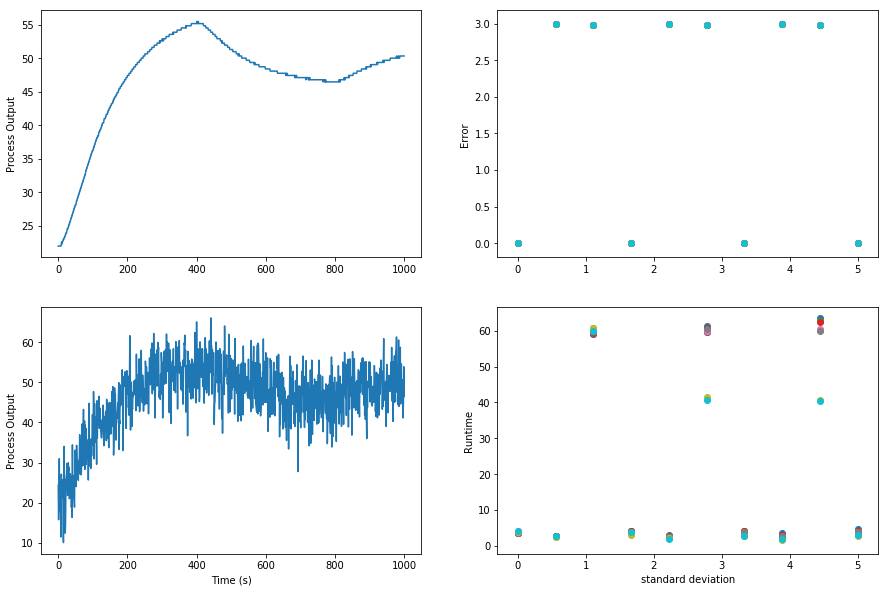

In [134]:
fig, ax = plt.subplots(2,2, figsize=(15,10)) 
ax[1,0].set_xlabel('Time (s)')
ax[1,1].set_xlabel('standard deviation')
ax[1,1].set_ylabel('Runtime')
ax[0,1].set_ylabel('Error')
ax[0,0].set_ylabel('Process Output')
ax[1,0].set_ylabel('Process Output')


oldname = ""
for dataname in os.listdir(input_datadir):
    for resultname in os.listdir(result_datadir):
        if dataname.endswith('.csv') and fnmatch.fnmatch(os.path.splitext(resultname)[0], os.path.splitext(dataname)[0]+'*') and fnmatch.fnmatch(resultname, '*m'+str(m)+'_n'+str(n)+'*'):
            if resultname.startswith(oldname[:25]):
                dfd = pandas.read_excel(result_datadir/resultname, sheet_name='Input_Data', header=None)
                dfr = pandas.read_excel(result_datadir/resultname, sheet_name='ID_Results', header=None)
                
                error = [0]
                for i in range(1,len(dfr)):
                    difference=[] 
                    for j in range(m+n):
                        difference.append(abs(dfr[j][0] - dfr[j][i]))
                    error.append(sum(difference))
                
                ax[0,1].scatter(dfr[m+n+1], error)
                ax[1,1].scatter(dfr[m+n+1], dfr[m+n])
           
            else:
                break
            oldname=resultname                   

# dfr[m+n].max()
ax[0,0].plot(dfd[1])
ax[1,0].plot(dfd[10])

In [112]:
df = pandas.read_excel(result_datadir/'Step1LSTSQ_rt_coeffs_m1_n1_0.xlsx', sheet_name='Input_Data', header=None)

In [121]:
df = pandas.read_excel(result_datadir/'Step1LSTSQ_rt_coeffs_m1_n1_0.xlsx', sheet_name='ID_Results', header=None)
df

,0,1,2,3
0,1.000000,1.000000,3.976978,0.000000
1,0.994373,0.003430,35.746728,0.555556
2,0.992993,0.004088,35.664536,1.111111
3,1.000000,1.000000,3.793391,1.666667
4,0.994373,0.003430,36.838863,2.222222
5,0.992993,0.004088,34.852063,2.777778
6,1.000000,1.000000,3.592820,3.333333
7,0.994373,0.003430,36.169015,3.888889
8,0.992993,0.004088,35.324601,4.444444
9,1.000000,1.000000,3.779655,5.000000


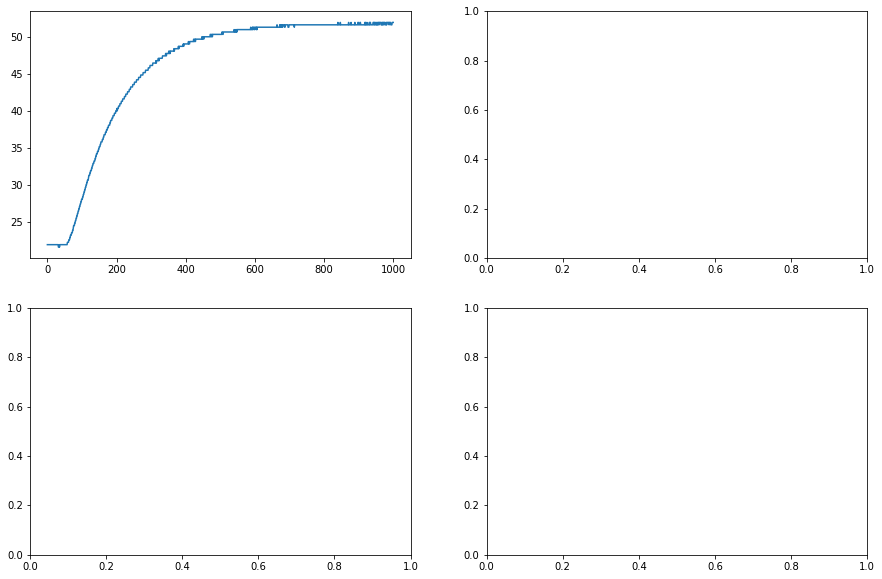

In [114]:
fig, ax = plt.subplots(2,2, figsize=(15,10)) 

ax[0,0].plot(df[1])

### Calculate the coefficient errors

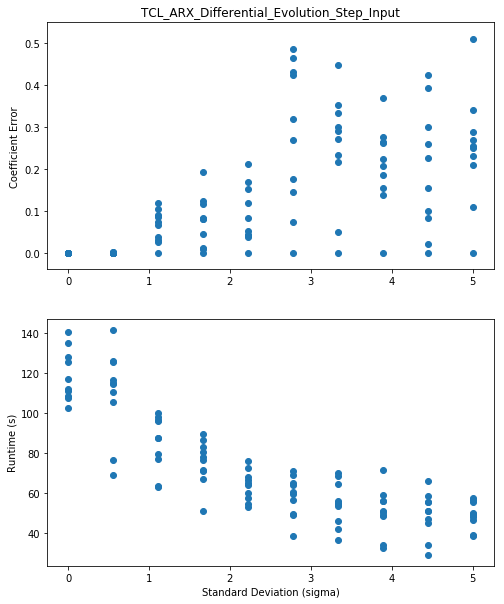

In [17]:
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(2,1,1)
ax1.set_ylabel("Coefficient Error")
ax1.set_title("TCL_ARX_Differential_Evolution_Step_Input")
ax2 = fig.add_subplot(2,1,2)
ax2.set_ylabel("Runtime (s)")
ax2.set_xlabel("Standard Deviation (sigma)")
ax1.scatter(np.array(Results.std_dev[1:]), np.concatenate(error, axis=0 )[1:])
ax2.scatter(Results.std_dev, Results.Runtime0)

In [ ]:
# get rt 140s .... index where runtime = 140 and sigma = 0
# Maybe always plot the slowest and the fastest one?